<a href="https://colab.research.google.com/github/Zardian18/FashionMnist-Autoencoders/blob/master/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Auto Encoders

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-01 10:33:47--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13084 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  12.78K  --.-KB/s    in 0s      

2024-01-01 10:33:47 (59.6 MB/s) - ‘helper.py’ saved [13084/13084]



## Fashion Mnist dataset

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test)= datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## Preprocessing the data

In [6]:
import numpy as np

def preprocess_img(imgs):
  imgs= imgs.astype("float32")/255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

In [7]:
x_train= preprocess_img(x_train)
x_test = preprocess_img(x_test)

In [8]:
x_train.shape

(60000, 32, 32, 1)

In [14]:
x_train[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

### Encoder

In [26]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose

In [22]:
encoder_input = Input(shape=(32,32,1), name="encoder_input")
x = Conv2D(filters=32,
           kernel_size=3,
           strides=2,
           activation="relu",
           padding="same")(encoder_input)
x = Conv2D(filters=64,
           kernel_size=3,
           strides=2,
           activation="relu",
           padding="same")(x)
x = Conv2D(filters=128,
           kernel_size=3,
           strides=2,
           activation="relu",
           padding="same")(x)
print(f"Shape before flatten: {x.shape}")
shape_before_flattening= x.shape[1:]
x= Flatten()(x)
encoder_output= Dense(2, name="encoder_output")(x) # 2d embeddings for the dense layer

encoder= tf.keras.Model(encoder_input, encoder_output)

Shape before flatten: (None, 4, 4, 128)


In [23]:
shape_before_flattening

TensorShape([4, 4, 128])

In [24]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

### Decoder

In [27]:
decoder_input= Input(shape=(2,), name="decoder_input")
x= Dense(np.prod(shape_before_flattening))(decoder_input)
x= Reshape(shape_before_flattening)(x)
x= Conv2DTranspose(filters= 128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x= Conv2DTranspose(filters= 64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x= Conv2DTranspose(filters= 32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
decoder_output= Conv2D(1, kernel_size=3, strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder= tf.keras.Model(decoder_input, decoder_output)

In [28]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [29]:
autoencoder= tf.keras.Model(encoder_input, decoder(encoder_output))

In [30]:
autoencoder.compile(loss="binary_crossentropy",
                    optimizer= tf.keras.optimizers.Adam())

In [31]:
autoencoder.fit(x_train, x_train, epochs=5, batch_size=100, shuffle= True, validation_data=(x_test, x_test))

Epoch 1/5
600/600 [==============================] - 234s 387ms/step - loss: 0.2934 - val_loss: 0.2623
Epoch 2/5
600/600 [==============================] - 219s 364ms/step - loss: 0.2568 - val_loss: 0.2563
Epoch 3/5
600/600 [==============================] - 227s 378ms/step - loss: 0.2532 - val_loss: 0.2534
Epoch 4/5
600/600 [==============================] - 216s 360ms/step - loss: 0.2514 - val_loss: 0.2522
Epoch 5/5
600/600 [==============================] - 217s 361ms/step - loss: 0.2500 - val_loss: 0.2513


In [32]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_4 (Functional)        (None, 32, 32, 1)         2462

In [34]:
from helper import display

In [33]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 8s 53ms/step
Example real clothing items


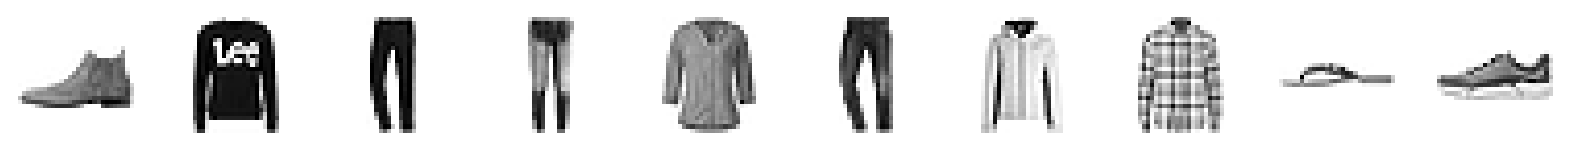

Reconstructions


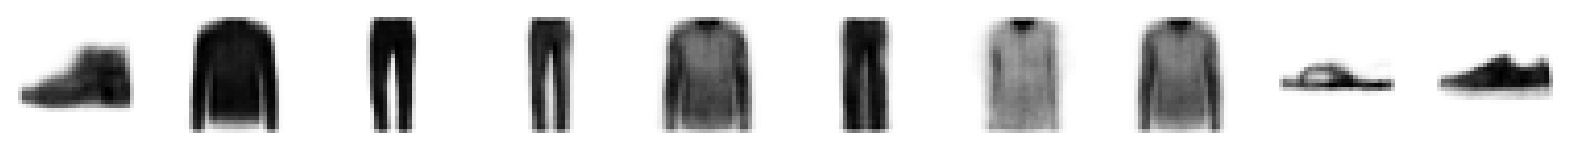

In [48]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

In [36]:
predictions.shape

(5000, 32, 32, 1)

In [40]:
import matplotlib.pyplot as plt

In [37]:
predictions[0]

array([[[1.6524640e-04],
        [1.8115614e-05],
        [3.9692230e-05],
        ...,
        [3.6485421e-06],
        [7.3113415e-06],
        [3.8038468e-04]],

       [[2.2976996e-05],
        [8.5826395e-07],
        [4.2135289e-06],
        ...,
        [2.8077622e-07],
        [3.6879993e-07],
        [2.5604673e-05]],

       [[2.4686437e-05],
        [2.3358607e-06],
        [7.1282731e-05],
        ...,
        [1.8351100e-05],
        [6.1039236e-06],
        [2.1635255e-04]],

       ...,

       [[8.1446240e-07],
        [2.5654664e-08],
        [1.1527408e-07],
        ...,
        [1.0168450e-07],
        [3.8450633e-08],
        [5.0086651e-06]],

       [[3.7615703e-06],
        [1.6055741e-07],
        [1.8955951e-06],
        ...,
        [6.6782104e-07],
        [9.8949087e-08],
        [1.0972779e-05]],

       [[1.5377090e-04],
        [1.9515515e-05],
        [4.2864256e-05],
        ...,
        [1.3225107e-05],
        [4.1320795e-06],
        [1.4482799e-04]]

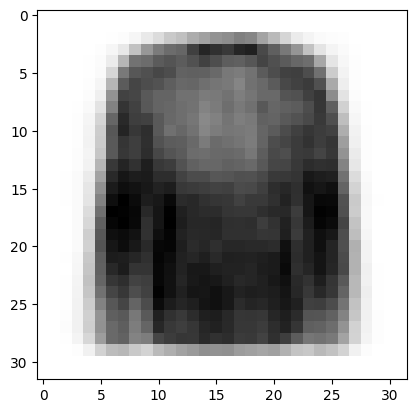

In [50]:
plt.imshow(predictions[500], cmap="gray_r");

## Visualizing latent space

In [54]:
import pandas as pd

labels_df= pd.DataFrame({"Clothing_type":["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]}, index= np.arange(10))

157/157 [==============================] - 1s 6ms/step


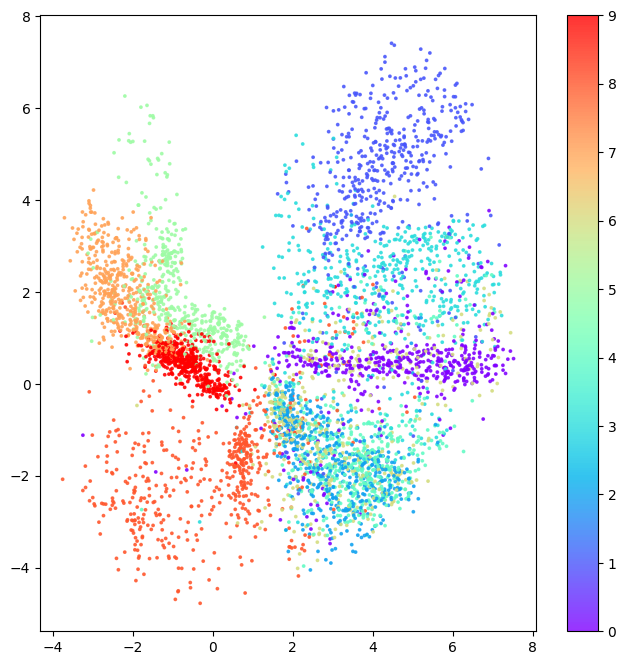

In [52]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.colorbar()
plt.show();

In [55]:
labels_df

,Clothing_type
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag
9,Ankle boot


## Generating new images

We need to give a point in the latent space so that a new novel image can be generated

In [72]:
mins, maxs= np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample= np.random.uniform(mins, maxs, size=(18,2))
reconstructions= decoder.predict(sample)

1/1 [==============================] - 0s 55ms/step


In [84]:
sample.shape

(18, 2)

In [77]:
mins, maxs

(array([-3.7485116, -4.7776117], dtype=float32),
 array([7.522208, 7.412799], dtype=float32))

In [57]:
reconstructions.shape

(18, 32, 32, 1)

In [62]:
emb2= encoder.predict(reconstructions)
emb2

1/1 [==============================] - 0s 29ms/step


array([[ 1.4817053 ,  1.1409708 ],
       [ 1.7057177 , -3.6095    ],
       [ 2.8107305 ,  0.9166423 ],
       [ 6.583114  ,  5.7110696 ],
       [-1.0738956 ,  4.4683356 ],
       [ 0.74097335,  0.96457124],
       [ 5.4886923 ,  1.0308481 ],
       [ 2.0817199 ,  2.6944559 ],
       [ 0.13378409,  1.7660238 ],
       [ 1.6837538 ,  1.5102079 ],
       [ 4.5723248 , -3.175867  ],
       [ 4.4044538 ,  0.38999173],
       [ 3.8728333 ,  3.6111004 ],
       [ 4.2518783 , -3.6131678 ],
       [-2.5510566 , -3.3348892 ],
       [ 4.256821  ,  2.7346518 ],
       [ 0.86259055, -2.9522202 ],
       [ 3.1813264 , -3.4074216 ]], dtype=float32)

In [63]:
embeddings[:5]

array([[-1.1264518,  1.1669405],
       [ 3.945458 , -2.6391451],
       [ 6.068907 ,  6.008493 ],
       [ 3.6743255,  4.09929  ],
       [ 1.9493582, -1.2793785]], dtype=float32)

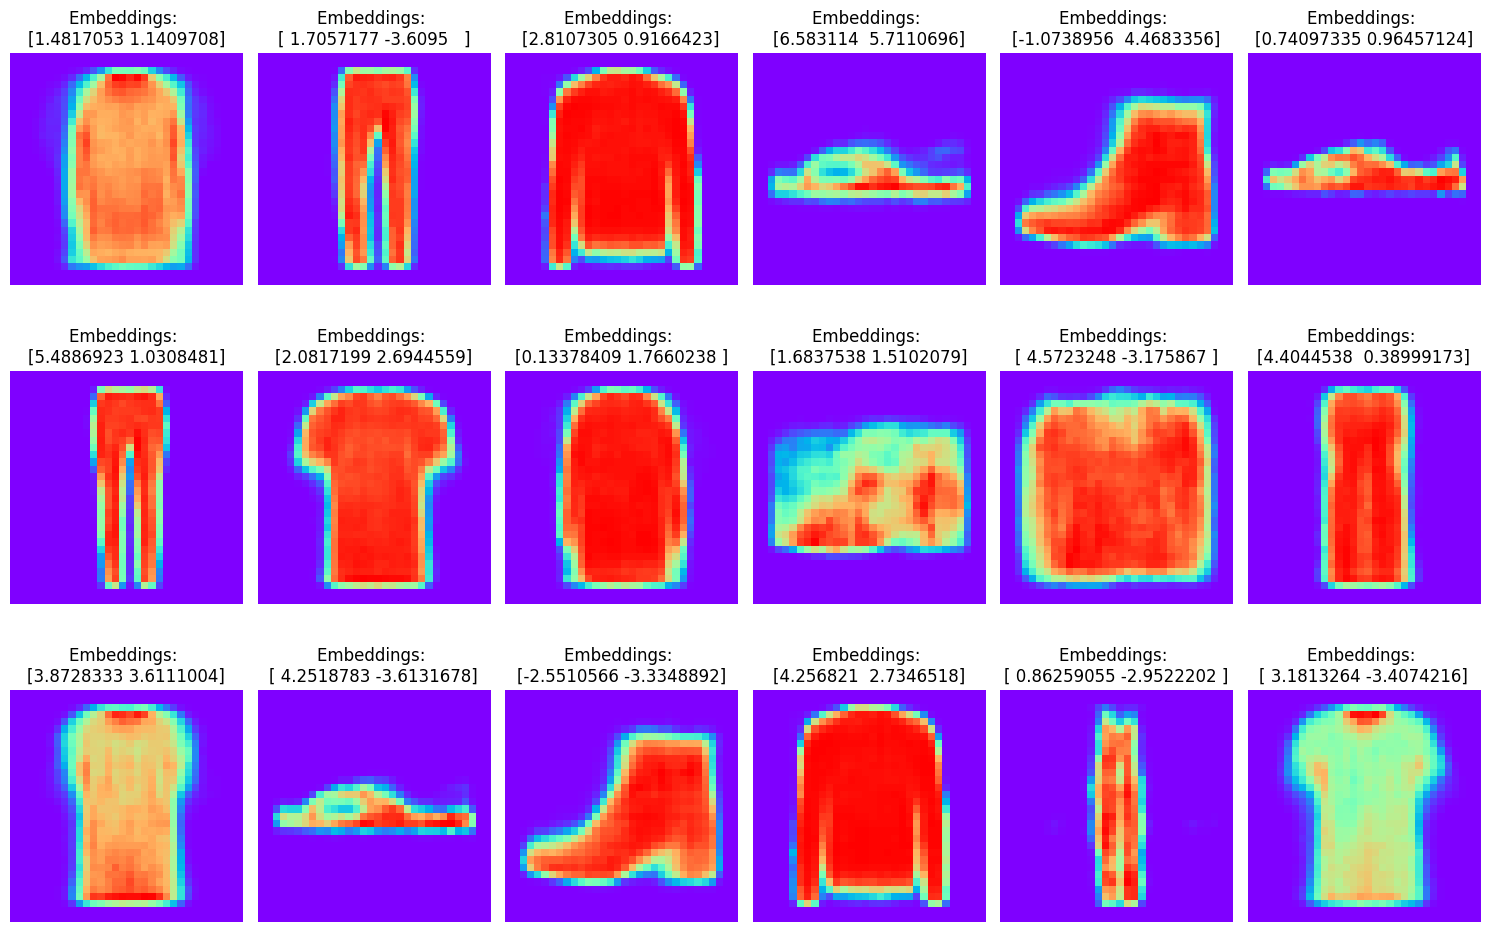

In [73]:
num_images = reconstructions.shape[0]
num_rows = 3
num_cols = int(np.ceil(num_images / num_rows))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx < num_images:
            ax[i, j].imshow(reconstructions[idx], cmap="rainbow")
            ax[i, j].set_title(f"Embeddings: \n{emb2[idx]}")
            ax[i, j].axis("off")
        else:

            ax[i, j].axis("off")
plt.tight_layout()
plt.show()

## Passing custom embeddings (2d vectors)

1/1 [==============================] - 0s 56ms/step


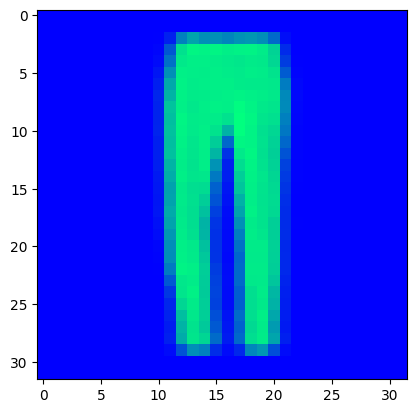

In [92]:
l = decoder.predict([[5,5]])
plt.imshow(l[0], cmap="winter");

In [88]:
l.shape

(1, 32, 32, 1)

`(5,5)` is indigo in the embeddings graph above, which corresponds to `label=1` and that is trousers. Therefore our model is making decent predictions

1/1 [==============================] - 0s 37ms/step


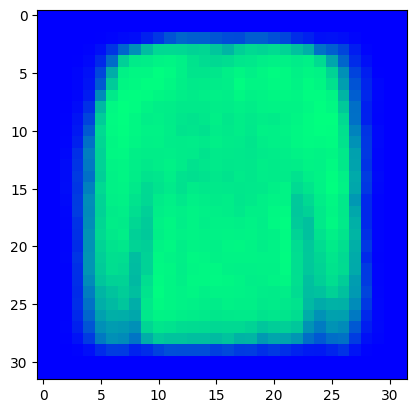

In [97]:
l = decoder.predict([[3,-4]]) # class2 = pullover
plt.imshow(l[0], cmap="winter");

1/1 [==============================] - 0s 95ms/step


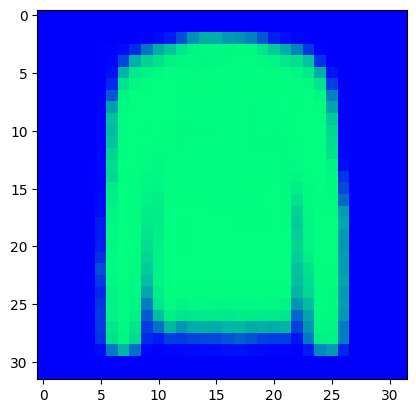

In [99]:
l = decoder.predict([[7,-4.5]]) # out of bounds but still predicts the closest label
plt.imshow(l[0], cmap="winter");

1/1 [==============================] - 0s 52ms/step


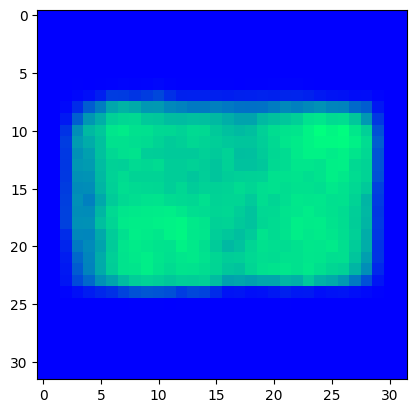

In [101]:
l = decoder.predict([[-2,-3]]) # label for bag
plt.imshow(l[0], cmap="winter");

1/1 [==============================] - 0s 41ms/step


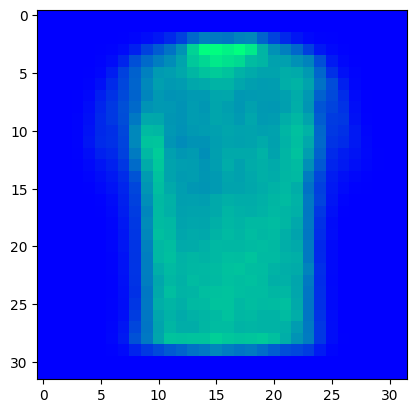

In [103]:
l = decoder.predict([[3,0]]) # shirt
plt.imshow(l[0], cmap="winter");